# 添加缩小图片的程序
## 首先是深度图缩小

In [1]:
# 导入相关包
from utils.dataset_processing.image import *
from utils.dataset_processing.grasp import *
from utils.data.jacquard_data_t import JacquardDataset

import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import rotate, resize, rescale

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


class Image:
    """
    Wrapper around an image with some convenient functions.
    """
    def __init__(self, img):
        self.img = img

    def __getattr__(self, attr):
        # Pass along any other methods to the underlying ndarray
        return getattr(self.img, attr)

    @classmethod
    def from_file(cls, fname):
        return cls(imread(fname))

    def copy(self):
        """
        :return: Copy of self.
        """
        return self.__class__(self.img.copy())

    def crop(self, top_left, bottom_right, resize=None):
        """
        Crop the image to a bounding box given by top left and bottom right pixels.
        :param top_left: tuple, top left pixel.
        :param bottom_right: tuple, bottom right pixel
        :param resize: If specified, resize the cropped image to this size
        """
        self.img = self.img[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        if resize is not None:
            self.resize(resize)

    def cropped(self, *args, **kwargs):
        """
        :return: Cropped copy of the image.
        """
        i = self.copy()
        i.crop(*args, **kwargs)
        return i

    def normalise(self):
        """
        Normalise the image by converting to float [0,1] and zero-centering
        """
        self.img = self.img.astype(np.float32)/255.0
        self.img -= self.img.mean()

    def resize(self, shape):
        """
        Resize image to shape.
        :param shape: New shape.
        """
        if self.img.shape == shape:
            return
        self.img = resize(self.img, shape, preserve_range=True).astype(self.img.dtype)

    def resized(self, *args, **kwargs):
        """
        :return: Resized copy of the image.
        """
        i = self.copy()
        i.resize(*args, **kwargs)
        return i

    def rotate(self, angle, center=None):
        """
        Rotate the image.
        :param angle: Angle (in radians) to rotate by.
        :param center: Center pixel to rotate if specified, otherwise image center is used.
        """
        if center is not None:
            center = (center[1], center[0])
        self.img = rotate(self.img, angle/np.pi*180, center=center, mode='symmetric', preserve_range=True).astype(self.img.dtype)

    def rotated(self, *args, **kwargs):
        """
        :return: Rotated copy of image.
        """
        i = self.copy()
        i.rotate(*args, **kwargs)
        return i

    def show(self, ax=None, **kwargs):
        """
        Plot the image
        :param ax: Existing matplotlib axis (optional)
        :param kwargs: kwargs to imshow
        """
        if ax:
            ax.imshow(self.img, **kwargs)
        else:
            plt.imshow(self.img, **kwargs)
            plt.show()

    def zoom(self, factor):
        """
        "Zoom" the image by cropping and resizing.
        :param factor: Factor to zoom by. e.g. 0.5 will keep the center 50% of the image.
        """
        sr = int(self.img.shape[0] * (1 - factor)) // 2
        sc = int(self.img.shape[1] * (1 - factor)) // 2
        orig_shape = self.img.shape
        self.img = self.img[sr:self.img.shape[0] - sr, sc: self.img.shape[1] - sc].copy()
        self.img = resize(self.img, orig_shape, mode='symmetric', preserve_range=True).astype(self.img.dtype)

    def zoomed(self, *args, **kwargs):
        """
        :return: Zoomed copy of the image.
        """
        i = self.copy()
        i.zoom(*args, **kwargs)
        return i


class DepthImage(Image):
    def __init__(self, img):
        super().__init__(img)

    @classmethod
    def from_pcd(cls, pcd_filename, shape, default_filler=0, index=None):
        """
            Create a depth image from an unstructured PCD file.
            If index isn't specified, use euclidean distance, otherwise choose x/y/z=0/1/2
        """
        img = np.zeros(shape)
        if default_filler != 0:
            img += default_filler

        with open(pcd_filename) as f:
            for l in f.readlines():
                ls = l.split()

                if len(ls) != 5:
                    # Not a point line in the file.
                    continue
                try:
                    # Not a number, carry on.
                    float(ls[0])
                except ValueError:
                    continue

                i = int(ls[4])
                r = i // shape[1]
                c = i % shape[1]

                if index is None:
                    x = float(ls[0])
                    y = float(ls[1])
                    z = float(ls[2])

                    img[r, c] = np.sqrt(x ** 2 + y ** 2 + z ** 2)

                else:
                    img[r, c] = float(ls[index])

        return cls(img/1000.0)

    @classmethod
    def from_tiff(cls, fname):
        return cls(imread(fname))

    def inpaint(self, missing_value=0):
        """
        Inpaint missing values in depth image.
        :param missing_value: Value to fill in teh depth image.
        """
        # cv2 inpainting doesn't handle the border properly
        # https://stackoverflow.com/questions/25974033/inpainting-depth-map-still-a-black-image-border
        self.img = cv2.copyMakeBorder(self.img, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
        mask = (self.img == missing_value).astype(np.uint8)

        # Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
        scale = np.abs(self.img).max()
        self.img = self.img.astype(np.float32) / scale  # Has to be float32, 64 not supported.
        self.img = cv2.inpaint(self.img, mask, 1, cv2.INPAINT_NS)

        # Back to original size and value range.
        self.img = self.img[1:-1, 1:-1]
        self.img = self.img * scale

    def gradients(self):
        """
        Compute gradients of the depth image using Sobel filtesr.
        :return: Gradients in X direction, Gradients in Y diretion, Magnitude of XY gradients.
        """
        grad_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, borderType=cv2.BORDER_DEFAULT)
        grad_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, borderType=cv2.BORDER_DEFAULT)
        grad = np.sqrt(grad_x ** 2 + grad_y ** 2)

        return DepthImage(grad_x), DepthImage(grad_y), DepthImage(grad)

    def normalise(self):
        """
        Normalise by subtracting the mean and clippint [-1, 1]
        """
        self.img = np.clip((self.img - self.img.mean()), -1, 1)


class WidthImage(Image):
    """
    A width image is one that describes the desired gripper width at each pixel.
    """
    def zoom(self, factor):
        """
        "Zoom" the image by cropping and resizing.  Also scales the width accordingly.
        :param factor: Factor to zoom by. e.g. 0.5 will keep the center 50% of the image.
        """
        super().zoom(factor)
        self.img = self.img/factor

    def normalise(self):
        """
        Normalise by mapping [0, 150] -> [0, 1]
        """
        self.img = np.clip(self.img, 0, 150.0)/150.0

In [3]:
def pad_width(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
def get_gradation_2d(start, stop, width, height, is_horizontal):
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T

In [4]:
train_dataset = JacquardDataset('../jacquard', start=0.0, end=0.9, ds_rotate=0.0,
                            random_rotate=True, random_zoom=True,ADJ = 0,npy_path = 0,
                            include_depth=1, include_rgb=0)

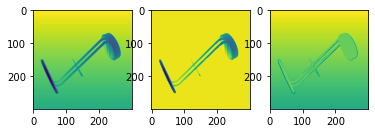

In [5]:
%matplotlib inline
# 先试一下直接用减法获取背景行不行
depth = train_dataset.get_depth(900)
plt.subplot(131)
plt.imshow(depth)
mask = train_dataset.get_mask(900) // 252.0
plt.subplot(132)
plt.imshow(mask * depth)
plt.subplot(133)
plt.imshow(depth-mask * depth)
plt.show()

纵向渐变


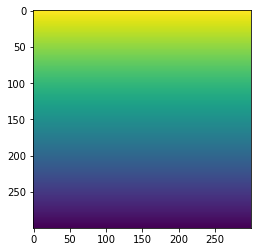

In [6]:
# 效果不太好,还是抠出来在生成背景吧
# 检查是横向渐变还是纵向渐变
if abs(sum(depth[0] - depth [-1])) < 1:
    print('横向渐变')
    is_horizontal = True
else:
    print('纵向渐变')
    is_horizontal = False
backgroud = get_gradation_2d(depth[0][0],depth[-1][-1],300,300,is_horizontal=is_horizontal)
plt.imshow(backgroud)
plt.show()

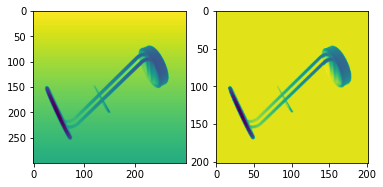

202.5


In [7]:
%matplotlib inline
depth = train_dataset.get_depth(900)
plt.subplot(121)
plt.imshow(depth)
maskdepth = train_dataset.get_mask(900) / 255.0

scale = 0.675

small = rescale(maskdepth * depth,[scale,scale])
plt.subplot(122)
plt.imshow(small)
plt.show()
print(300*0.675)

(298, 298)
(300, 300)


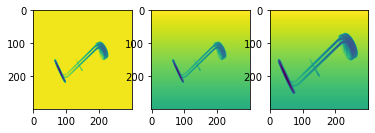

In [8]:
paded = np.pad(small,int((300*(1-scale))/2),pad_width)
print(paded.shape)
paded_img = Image(paded)
paded_img.resize((300,300))
print(paded_img.shape)
plt.subplot(131)
plt.imshow(paded_img.img)
plt.subplot(132)
plt.imshow(paded_img.img + backgroud)
plt.subplot(133)
plt.imshow(depth)
plt.show()

1
横向渐变


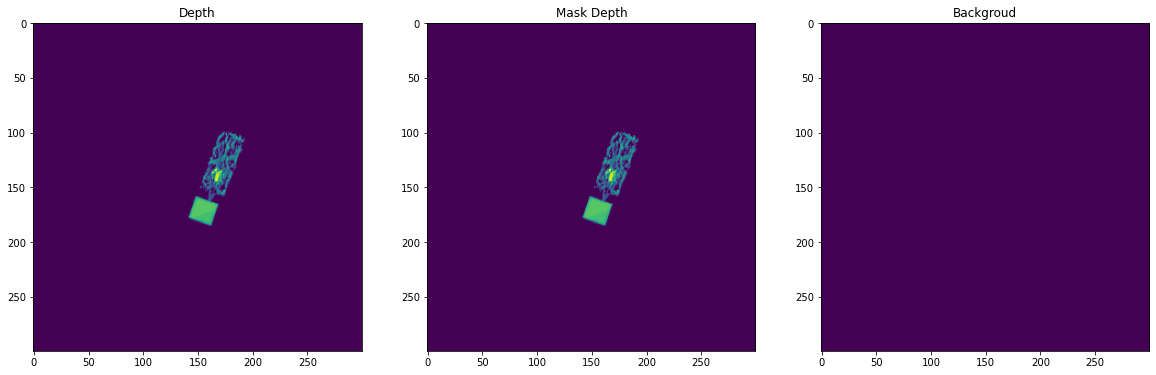

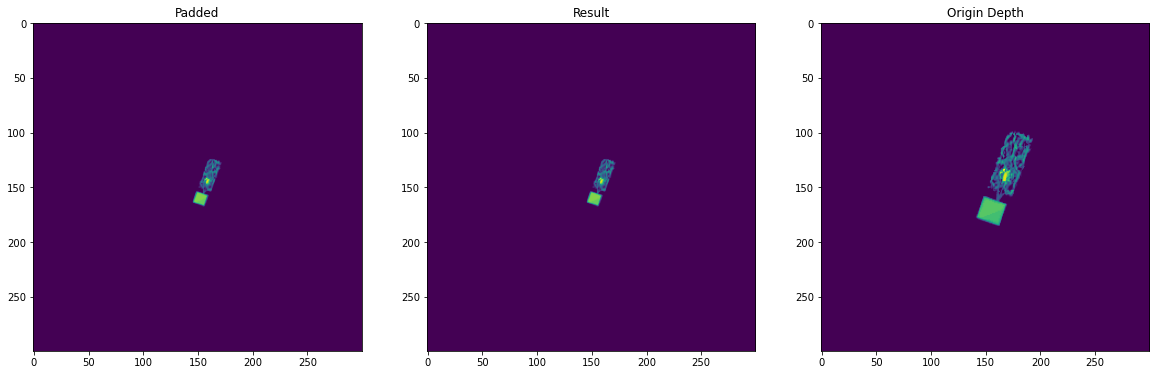

In [10]:
%matplotlib inline 
# 上面的程序整理一下
# 首先读取图片
idx = 800
print(1)
for idx in range(40000):
    depth = train_dataset.get_mask_prob(idx)
    mask = (train_dataset.get_mask(idx) // 50.0).astype(np.bool)
    scale = 0.5
    if sum(sum(mask)) / 90000 < 0.02:
        continue
    shape = depth.shape
    # 看一下是横向渐变还是纵向渐变,然后给他生成背景,其实都是纵向的,之前看到的横向的是旋转过的
    if abs(sum(depth[0] - depth [-1])) < 1:
        print('横向渐变')
        is_horizontal = True
    else:
        print('纵向渐变')
        is_horizontal = False
    # 消除原始背景影响
    origin_backgroud = get_gradation_2d(depth[0][0],depth[-1][-1],300,300,is_horizontal=is_horizontal)
    mask_depth = mask * (depth-origin_backgroud)
    # 按照比例生成新的背景
    backgroud = get_gradation_2d(depth[0][0] / scale,depth[-1][-1] / scale,300,300,is_horizontal=is_horizontal)
    # 可视化看一下
    plt.figure(figsize = (20,20))
    plt.subplot(131)
    plt.title('Depth')
    plt.imshow(depth)
    plt.subplot(132)
    plt.title('Mask Depth')
    plt.imshow(mask_depth)
    plt.subplot(133)
    plt.title('Backgroud')
    plt.imshow(backgroud)
    plt.show()

    # 缩小图片
    scaled_img = rescale(mask_depth,[scale,scale])
    scaled_background = rescale(backgroud,[scale,scale])
    # 填充图片
    paded = np.pad(scaled_img,int((300*(1-scale))/2),pad_width)
    paded_backgroud = np.pad(scaled_background,int((300*(1-scale))/2),pad_width)
    # 缩放图片
    paded_img = resize(paded, shape, preserve_range=True).astype(paded_img.dtype)
    scaled_backgroud = resize(paded_backgroud, shape, preserve_range=True).astype(paded_backgroud.dtype)

    # 添加背景
    result = paded_img + backgroud
    plt.figure(figsize = (20,20))
    plt.subplot(131)
    plt.title('Padded')
    plt.imshow(paded)
    plt.subplot(132)
    plt.title('Result')
    plt.imshow(result)
    plt.subplot(133)
    plt.title('Origin Depth')
    plt.imshow(depth)
    plt.show()
    break

In [58]:
%matplotlib auto
plt.imshow(depth)
plt.show()

Using matplotlib backend: Qt5Agg


In [61]:
scaled_img = rescale(depth,[0.5,0.5],multichannel=1)
plt.imshow(scaled_img)

In [62]:
paded = np.pad(scaled_img,int((300*(1-scale))/2),pad_width)

In [68]:
backgroud = imread('R-C.jpeg') * mask.reshape(300,300,1)
plt.imshow(backgroud)

ValueError: operands could not be broadcast together with shapes (1024,1024,3) (300,300,1) 

## 抓取缩小
深度图缩小搞定了,下面是抓取缩小,让标注跟它保持一致

感觉最多**缩小两倍**就行了,不能太多

抓取这里面用到的是zoom这个函数,现在看来好像是不用变的,直接就能用